In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import shap
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_PATH = "/content/drive/MyDrive/transformation_classifier"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval()

print("✅ Model and tokenizer loaded successfully from Google Drive!")


✅ Model and tokenizer loaded successfully from Google Drive!


In [7]:
#  3. Define Label Mapping
# ===============================
label_map = {
    0: "Active to Passive",
    1: "Direct to Indirect",
    2: "Indirect to Direct",
    3: "Negative to Positive",
    4: "Passive to Active",
    5: "Positive to Negative"
}

In [17]:
import shap
import numpy as np
import torch
import torch.nn.functional as F
from transformers import pipeline

# Build a Hugging Face pipeline from your saved model
pipe = pipeline("text-classification",
                model=model,
                tokenizer=tokenizer,
                return_all_scores=True)

# Wrap the pipeline in a SHAP explainer
explainer = shap.Explainer(pipe)

# Explain a list of texts  ← note the brackets
example_texts = ["She is writing a letter."]
shap_values = explainer(example_texts)

# Visualize the first explanation
shap.plots.text(shap_values[0])



Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
PartitionExplainer explainer: 2it [00:11, 11.89s/it]               


In [18]:
# Initialize SHAP explainer (sample-based)
explainer = shap.Explainer(predict_proba, tokenizer)
print("✅ SHAP explainer initialized successfully!")


✅ SHAP explainer initialized successfully!


RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


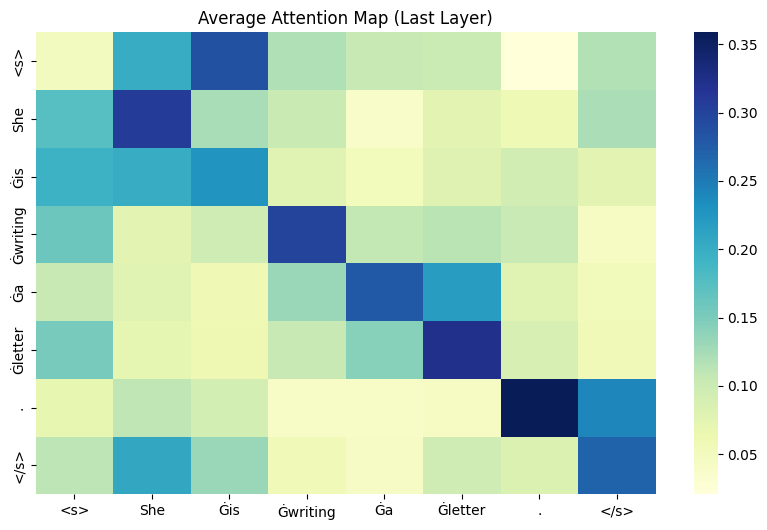

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[-1][0].detach().numpy()   # last layer

    avg_attn = np.mean(attn, axis=0)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    plt.figure(figsize=(10,6))
    sns.heatmap(avg_attn, xticklabels=tokens, yticklabels=tokens, cmap="YlGnBu")
    plt.title("Average Attention Map (Last Layer)")
    plt.show()

visualize_attention("She is writing a letter.")


In [20]:
def classify_transformation(original, transformed):
    # Tokenize only the transformed sentence (as per task)
    inputs = tokenizer(transformed, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_idx].item()

    # Prepare readable output
    return {
        "Predicted Transformation": label_map[pred_idx],
        "Confidence": round(confidence * 100, 2)
    }

In [ ]:
#Gradio Interface
# ===============================
def gradio_predict(original, transformed):
    result = classify_transformation(original, transformed)
    return f"**Prediction:** {result['Predicted Transformation']}\n**Confidence:** {result['Confidence']}%"

demo = gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Textbox(label="Original Sentence", placeholder="Enter the original sentence"),
        gr.Textbox(label="Transformed Sentence", placeholder="Enter the transformed sentence")
    ],
    outputs="markdown",
    title="🧠 Sentence Transformation Classifier",
    description="Classify sentence transformations (Active↔Passive, Direct↔Indirect, Positive↔Negative).",
    examples=[
        ["He is eating an apple.", "An apple is being eaten by him."],
        ["She said, 'I am tired.'", "She said that she was tired."],
        ["The movie is good.", "The movie is not good."]
    ]
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4c4390729749b57958.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
